<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №9
# Прогнозирование временных рядов методами глубокого обучения
**9 апреля 2025г.**

---

Задачу прогнозирования временных рядов можно эффективно решать методами глубокого обучения, особенно когда данные содержат нелинейные зависимости, сезонность или сложную динамику. Вот основные подходы и архитектуры, которые используются:

---

### 1. **Рекуррентные нейронные сети (RNN)**
Используются для последовательной обработки данных.

- **Vanilla RNN** — базовая форма RNN, редко используется из-за проблем исчезающего градиента.
- **LSTM (Long Short-Term Memory)** — популярный выбор, хорошо справляется с долговременными зависимостями.
- **GRU (Gated Recurrent Unit)** — упрощённая версия LSTM, быстрее обучается и требует меньше вычислений.

**Пример использования:**  
Вход: последовательность значений временного ряда  
Выход: значение (или несколько) на следующем шаге  

---

### 2. **1D-Сверточные сети (CNN для временных рядов)**
Могут извлекать локальные шаблоны в данных.

- Эффективны для коротких зависимостей и быстрых расчётов.
- Часто используются в комбинации с RNN/LSTM (например, CNN+LSTM).

---

### 3. **Encoder-Decoder архитектуры**
Подход из области машинного перевода, адаптированный к временным рядам:

- **Encoder** считывает входную последовательность.
- **Decoder** генерирует выходную последовательность (будущие значения).

---

### 4. **Transformer и его модификации**
Модель, изначально разработанная для NLP, показала себя отлично и в задаче прогнозирования временных рядов.

- **Informer, Autoformer, Transformer-XL, TimesNet** — специализированные архитектуры для временных рядов.
- Transformer позволяет учитывать долгосрочные зависимости благодаря механизмам внимания.

---

### 5. **Сети прямого распространения (MLP)**
Простые полносвязные сети можно применять, если на вход подаются фичи из скользящего окна (например, 10 предыдущих точек). Хорошо работают при небольшой сложности данных.

---

### 6. **Гибридные подходы**
Комбинации из разных типов сетей:
- **CNN+LSTM**
- **Encoder (CNN/LSTM) + Attention + Decoder**
- **Transformer + Residual MLP**

---

### Как строится вход для модели:
- **Скользящее окно**: берём последние `n` точек временного ряда как вход, предсказываем следующие `m` точек.
- Можно добавлять фичи:
  - Временные метки (час, день недели, месяц)
  - Внешние воздействия (управляющие сигналы, температура воздуха и т.д.)


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", rc={'figure.figsize':(15,6)})

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import lr_scheduler

from tqdm import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

## Загрузка данных
Набор содержит данные о почасовом производстве ветряной и солнечной электроэнергии (в МВт) во французской электросети с 2020 года.

In [3]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W', verify=False)

df = pd.read_csv('./intermittent-renewables-production-france.csv')

Downloading...
From: https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W
To: /content/intermittent-renewables-production-france.csv
100%|██████████| 5.12M/5.12M [00:00<00:00, 98.9MB/s]


In [4]:
df = pd.read_csv('intermittent-renewables-production-france.csv')
df = df.rename(columns={'Date and Hour' : 'DateTime'})
df['DateTime'] = df['DateTime'].str.slice(stop=-6)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(ascending=True,by='DateTime')
df = df.drop(['Date','dayOfYear','dayName','monthName'],axis=1)
df = df.dropna()
df = df.set_index("DateTime")

In [5]:
solar = df[df['Source'] == 'Solar']['Production']
wind = df[df['Source'] == 'Wind']['Production']

In [6]:
solar.head()

,Production
DateTime,
2020-01-01 00:00:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0


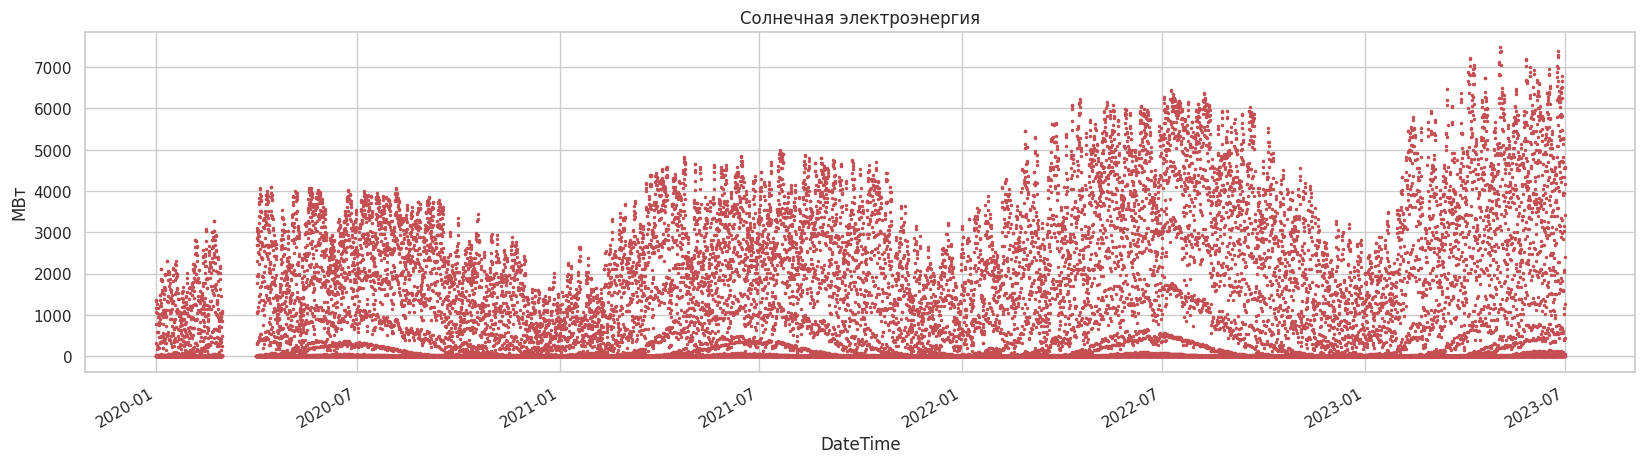

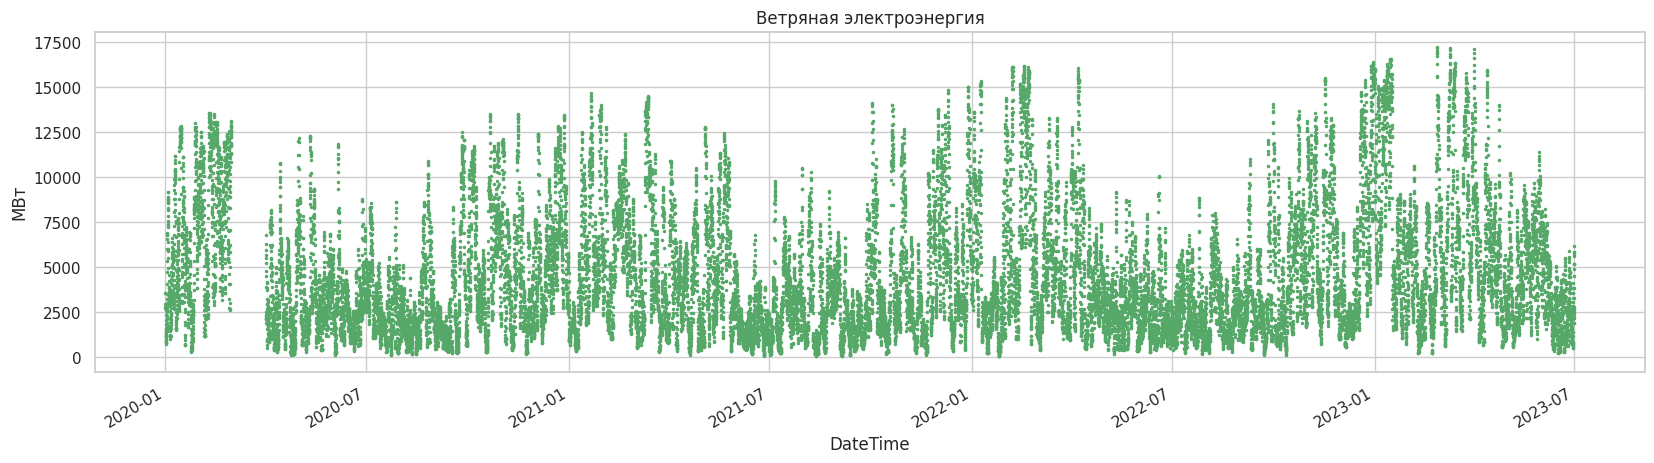

In [7]:
color_pal = sns.color_palette()
solar.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[3],
          title='Солнечная электроэнергия')
plt.ylabel("МВт")
plt.show()

wind.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[2],
          title='Ветряная электроэнергия')
plt.ylabel("МВт")
plt.show()

## Сформируем датасет на основе данных о производстве солнечной электроэнергии
### Разделим данные на обучающую и тестовую выборки

In [8]:
cutoff_date = '2023-01-01'

solar_train = solar[solar.index < cutoff_date].copy()
solar_test = solar[solar.index >= cutoff_date].copy()

print(f"Train: {solar_train.shape[0]} записей")
print(f"Test: {solar_test.shape[0]} записей")

Train: 25558 записей
Test: 4343 записей


### Нормализация или стандартизация данных

In [9]:
solar_scaler = preprocessing.MinMaxScaler() # нормализация данных
# solar_scaler = preprocessing.StandardScaler() # стандартизация данных

solar_train_scaled = pd.DataFrame(
    solar_scaler.fit_transform(solar_train.values[:, None]),
    index=solar_train.index)

solar_test_scaled = pd.DataFrame(
    solar_scaler.transform(solar_test.values[:, None]),
    index=solar_test.index)

solar_train_scaled.describe()

,0
count,25558.000000
mean,0.155712
std,0.225198
min,0.000000
25%,0.000155
50%,0.005895
75%,0.280329
max,1.000000


### Dataset и DataLoader

<img src="https://github.com/ArtyomShabunin/SMOPA-25/blob/main/imgs/l9_fig1.png?raw=true" alt="trend_seasonality" width="800"  align="center"/>

In [10]:
class SolarDataset(Dataset):
    def __init__(self, data, n_lags, horizon):
        self.n_lags = n_lags
        self.horizon = horizon
        data = data.reshape(-1)
        self.x = torch.tensor(data[:-self.horizon], dtype=torch.float32)
        self.y = torch.tensor(data[self.n_lags:],dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x[idx:idx+self.n_lags], self.y[idx:idx+self.horizon]

    def __len__(self):
        return self.y.shape[0]-self.horizon+1

In [11]:
N_LAGS = 10
HORIZON = 100
HIDDEN_DIM = 1024
HIDDEN_NUM = 2

solar_dataset = SolarDataset(solar_train_scaled.values, N_LAGS, HORIZON)
len(solar_dataset)

25449

In [12]:
solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 1024

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

## Предсказание производства солнечной электроэнергии
### Полносвязная нейронная сеть (многослойный персептрон)

#### Функция для обучения моделей

In [13]:
def train_model(model, loss_function, optimizer, scheduler, num_epochs=100):

  loaders = {"train": solar_train_loader, "valid": solar_valid_loader}
  losses = {"train": [], "valid": []}
  lr = []

  for epoch in tqdm(range(epochs)):

    for k, dataloader in loaders.items():
      running_loss = []

      for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        if k == "train":
          model.train()
          optimizer.zero_grad()
          out = model(x_batch, y_batch.shape[1])

        else:
          model.eval()
          with torch.no_grad():
            out = model(x_batch, y_batch.shape[1])

        loss = loss_function(out, y_batch)
        running_loss.append(loss.item())

        if k == "train":
          loss.backward()
          optimizer.step()

      losses[k].append(np.array(running_loss).mean())
    lr.append(scheduler.get_last_lr())
    scheduler.step(losses["train"][-1])

  return model, losses, lr

In [64]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_num=1):
        super(FeedForwardNN, self).__init__()
        self.hidden_num = hidden_num
        self.linear = nn.ModuleList()
        for i in range(self.hidden_num):
            if i == 0:
              self.linear.append(nn.Linear(input_dim, hidden_dim))
            else:
              self.linear.append(nn.Linear(hidden_dim, hidden_dim))
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, horizon):
        for i in range(self.hidden_num):
            x = F.relu(self.linear[i](x))
        result = self.out(x)
        return result

In [65]:
FC_model = FeedForwardNN(input_dim=N_LAGS,
                      hidden_dim=HIDDEN_DIM,
                      output_dim=HORIZON,
                      hidden_num=HIDDEN_NUM).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(FC_model.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 20

In [66]:
FC_model, losses, lr = train_model(FC_model, loss_fn, optimizer, scheduler, num_epochs=epochs)

100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


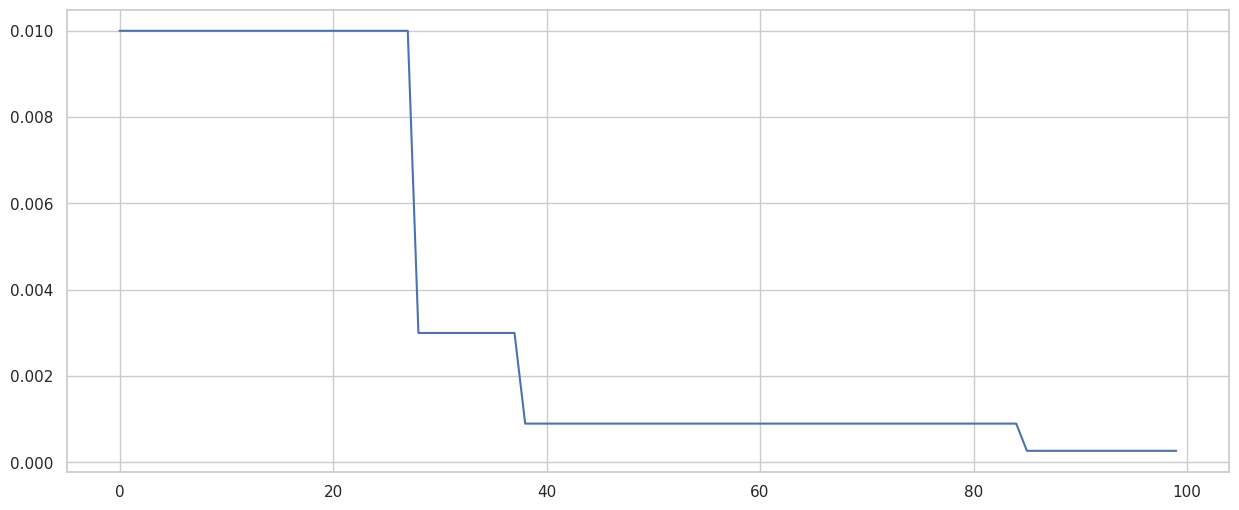

In [67]:
plt.plot(lr);

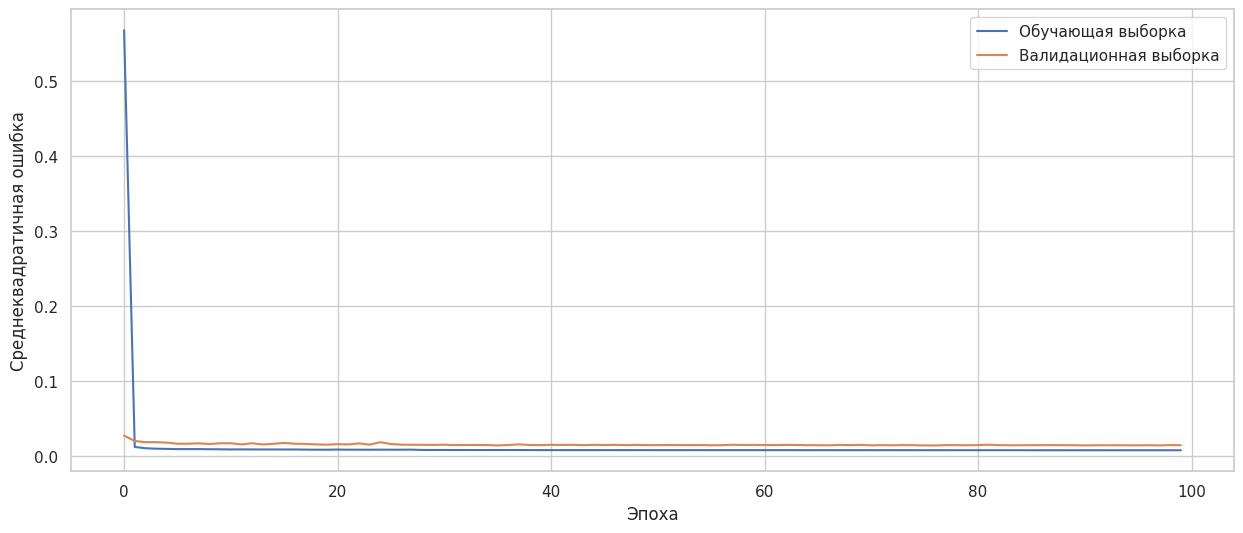

In [68]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Валидационная выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

In [69]:
print(f"Минимальный loss на тренировочной выборке: {min(losses['train']):.4f}")
print(f"Минимальный loss на валидационной выборке: {min(losses['valid']):.4f}")

Минимальный loss на тренировочной выборке: 0.0081
Минимальный loss на валидационной выборке: 0.0145


### Анализ качества модели

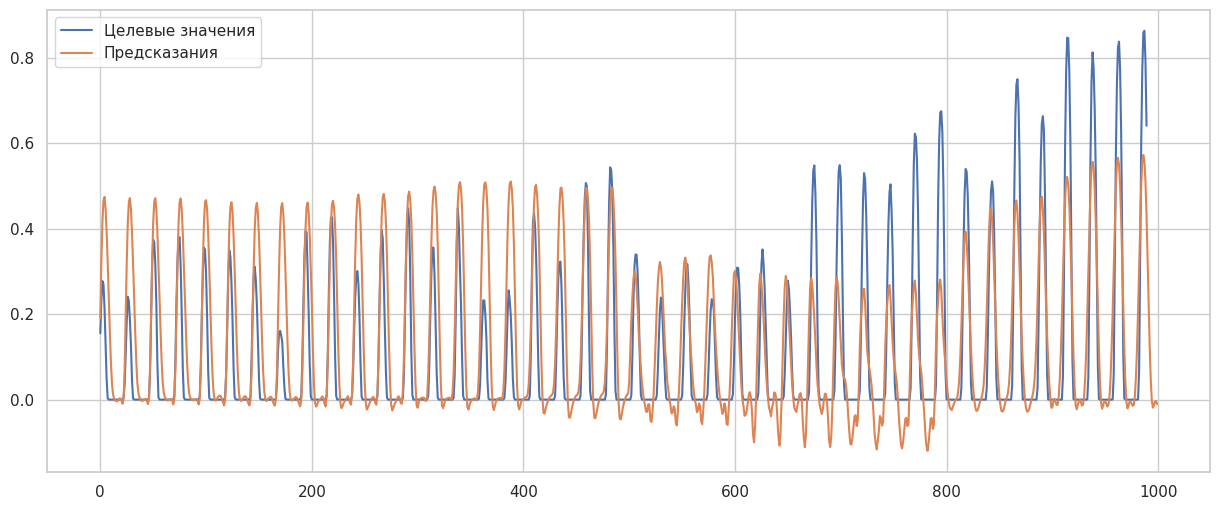

In [78]:
FC_model.to('cpu')

start = 0
predicted_steps = 10
in_data = solar_test_scaled.values[start:start+N_LAGS].reshape(-1)
for i in range(predicted_steps):
    out_data = FC_model(torch.tensor(in_data[-N_LAGS:], dtype=torch.float32), HORIZON)
    in_data = np.concatenate((in_data, out_data.detach().numpy()))

fc_pred = in_data[start+N_LAGS:]
plt.plot(
    solar_test_scaled.values[start+N_LAGS:start+predicted_steps*HORIZON],
    label="Целевые значения")
plt.plot(fc_pred, label="Предсказания");
# plt.xlim((0, solar_test_scaled.shape[0]))
plt.legend();


Базовая модель

In [79]:
solar_baseline_pred = np.array(
    [solar_test_scaled.mean() for _ in range(len(solar_test_scaled))])

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

In [80]:
from sklearn.metrics import mean_absolute_error

len_of_seq = np.min(
    [fc_pred.shape[0], solar_baseline_pred[N_LAGS:,:].shape[0]])

mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    fc_pred[:len_of_seq]
)

baseline_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    solar_baseline_pred[:len_of_seq]
)

print(f"MAE: {mae:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

MAE: 0.0855
Baseline MAE: 0.2002


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

In [81]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    fc_pred[:len_of_seq]
)

baseline_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    solar_baseline_pred[:len_of_seq]
)

print(f"RMSE: {rmse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")

RMSE: 0.0173
Baseline RMSE: 0.0478


In [51]:
len_of_seq

np.int64(4333)

In [49]:
solar_baseline_pred[N_LAGS:,:].shape[0]

4333

In [20]:


# mae = mean_absolute_error(
#     solar_dy_day_test['y'],
#     forecast['yhat'][-solar_dy_day_test.shape[0]:]
# )

# baseline_mae = mean_absolute_error(
#     solar_dy_day_test['y'],
#     solar_dy_day_baseline_pred
# )

# print(f"MAE: {mae:.2f}")
# print(f"Baseline MAE: {baseline_mae:.2f}")

### Рекуррентная нейронная сеть

**autoregressive LSTM**

- сначала модель "считывает" входной временной ряд длиной `n_lags`;
- затем **по одному** предсказывает `horizon` шагов вперёд;
- на каждом следующем шаге использует **предыдущее предсказание как вход**.


In [21]:
N_LAGS = 20
HORIZON = 20

solar_dataset = SolarDataset(solar_train_scaled.values, N_LAGS, HORIZON)

solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 1024

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

In [22]:
class LSTMForecastAuto(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input_seq, horizon):
        outputs = []

        input_seq = input_seq[:,:,None]

        lstm_out, (hn, cn) = self.lstm(input_seq)

        # Первый шаг – прямое предсказание
        pred = self.linear(lstm_out[:, -1, :])  # [batch, 1]
        outputs.append(pred)
        input = pred.unsqueeze(1)

        for _ in range(horizon - 1):
            out, (hn, cn) = self.lstm(input, (hn, cn))
            pred = self.linear(out[:, -1, :])
            outputs.append(pred)
            input = pred.unsqueeze(1)

        return torch.cat(outputs, dim=1)

In [23]:
HIDDEN_SIZE = 64
LSTM_LAYERS = 1

LSTM_model = LSTMForecastAuto(hidden_size=HIDDEN_SIZE, num_layers=LSTM_LAYERS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 100

In [24]:
LSTM_model, losses, lr = train_model(LSTM_model, loss_fn, optimizer, scheduler, num_epochs=epochs)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


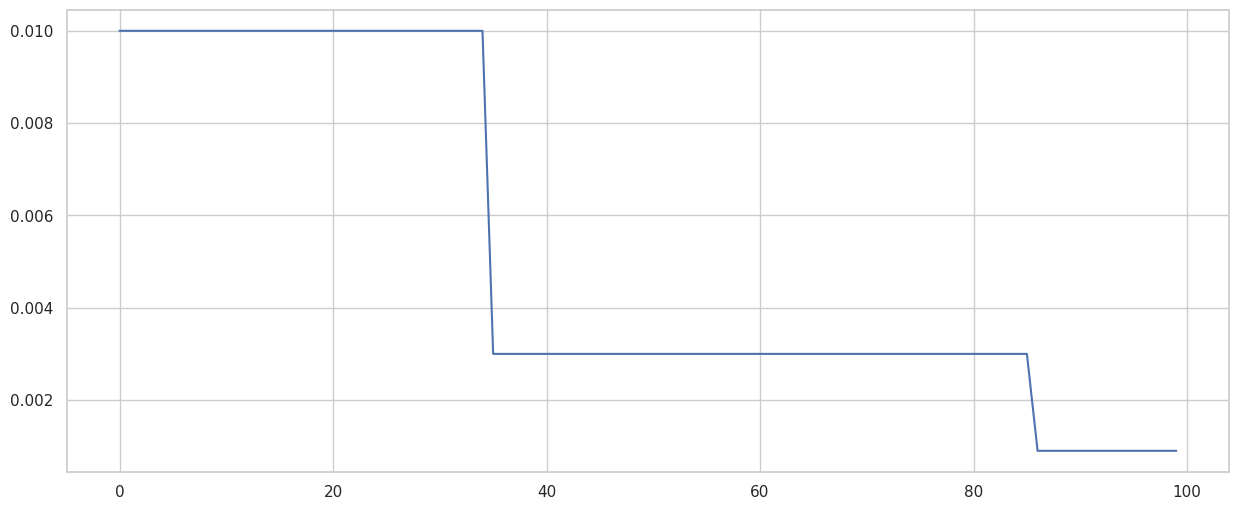

In [25]:
plt.plot(lr);

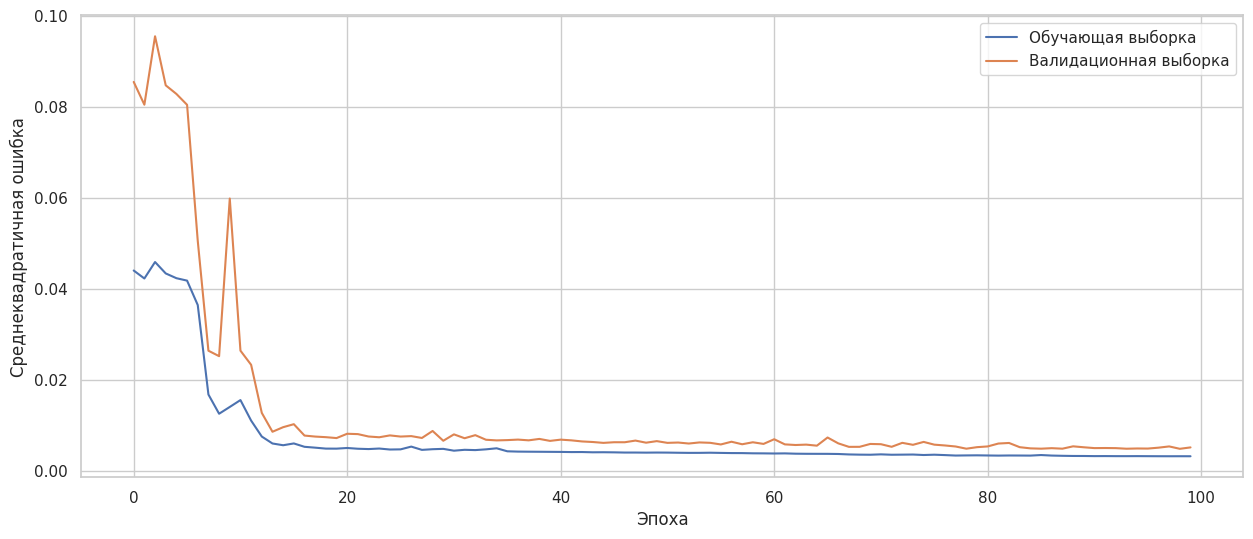

In [26]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Валидационная выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

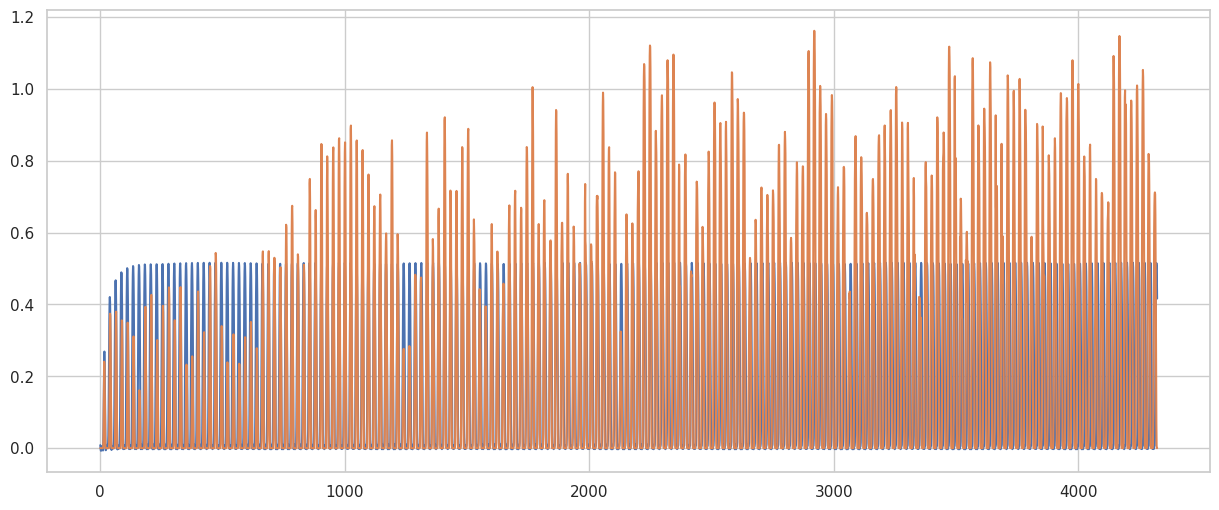

In [27]:
LSTM_model.to('cpu')

horizon_for_test = solar_test_scaled.shape[0] - N_LAGS

pred = LSTM_model(
    torch.tensor(
        solar_test_scaled.values[:N_LAGS].reshape(-1)[None,:],
        dtype=torch.float32),
    horizon_for_test
    # solar_test_scaled.shape[0] - N_LAGS
    )

plt.plot(pred[0].detach().numpy());
plt.plot(solar_test_scaled.values[N_LAGS:N_LAGS+horizon_for_test].reshape(-1));

In [82]:
df = pd.read_csv('intermittent-renewables-production-france.csv')
df = df.rename(columns={'Date and Hour' : 'DateTime'})
df['DateTime'] = df['DateTime'].str.slice(stop=-6)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['sin_dayOfYear'] = np.sin(2*np.pi*df['dayOfYear']/365)
df['cos_dayOfYear'] = np.cos(2*np.pi*df['dayOfYear']/365)

df = df.sort_values(ascending=True,by='DateTime')
df = df.drop(['Date','dayName','monthName', 'dayOfYear'],axis=1)
df = df.dropna()
df = df.set_index("DateTime")

In [83]:
solar = df[df['Source'] == 'Solar'][['Production', 'sin_dayOfYear', 'cos_dayOfYear']]
solar.head()

,Production,sin_dayOfYear,cos_dayOfYear
DateTime,,,
2020-01-01 00:00:00,0.0,0.017213,0.999852
2020-01-01 01:00:00,0.0,0.017213,0.999852
2020-01-01 02:00:00,0.0,0.017213,0.999852
2020-01-01 03:00:00,0.0,0.017213,0.999852
2020-01-01 04:00:00,0.0,0.017213,0.999852


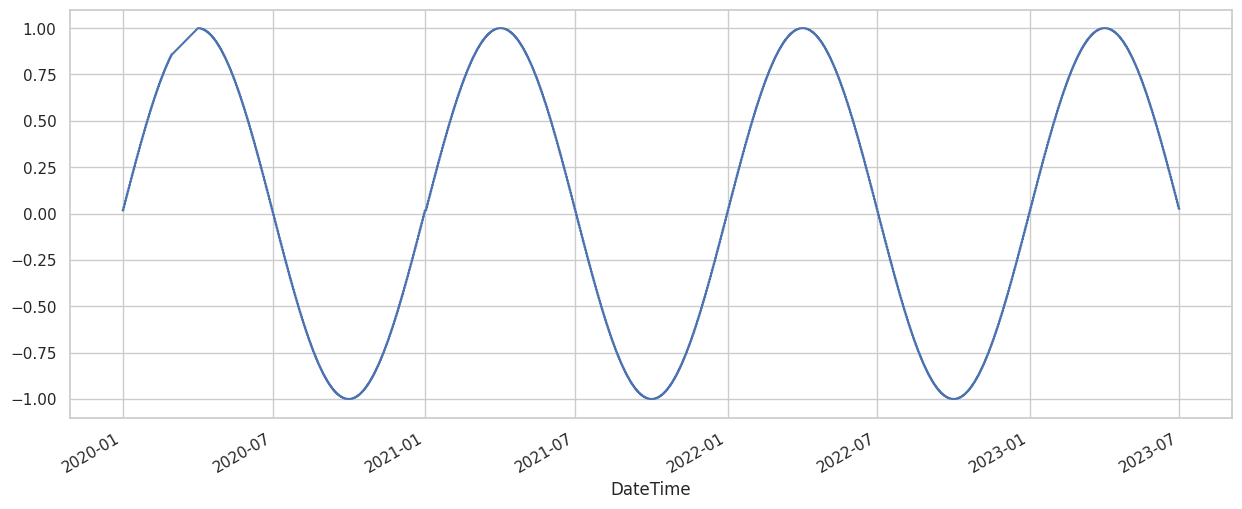

In [84]:
solar['sin_dayOfYear'].plot();

In [85]:
cutoff_date = '2023-01-01'

solar_train = solar[solar.index < cutoff_date].copy()
solar_test = solar[solar.index >= cutoff_date].copy()

print(f"Test: {solar_test.shape[0]} записей")

Test: 4343 записей


In [86]:
solar_scaler = preprocessing.MinMaxScaler() # нормализация данных
# solar_scaler = preprocessing.StandardScaler() # стандартизация данных

solar_train_scaled = pd.DataFrame(
    solar_scaler.fit_transform(solar_train.values[:]),
    index=solar_train.index)

solar_test_scaled = pd.DataFrame(
    solar_scaler.transform(solar_test.values[:]),
    index=solar_test.index)

solar_train_scaled.describe()

,0,1,2
count,25558.000000,25558.000000,25558.000000
mean,0.155712,0.486079,0.496724
std,0.225198,0.348833,0.357949
min,0.000000,0.000000,0.000000
25%,0.000155,0.138175,0.139650
50%,0.005895,0.478489,0.476330
75%,0.280329,0.827581,0.863301
max,1.000000,1.000000,1.000000


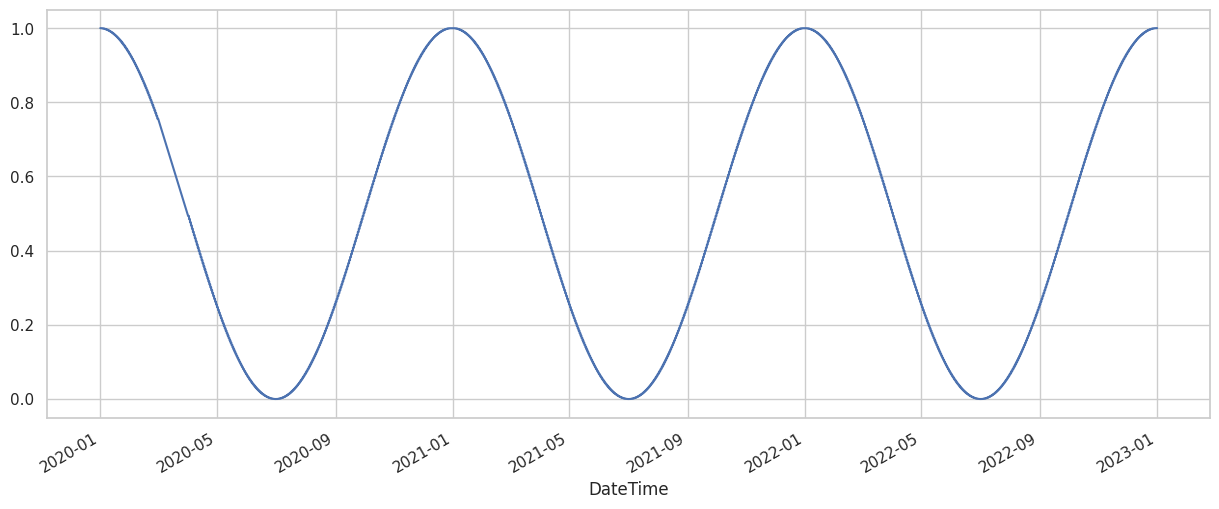

In [87]:
solar_train_scaled[2].plot();

In [88]:
class SolarDatasetWithSin(Dataset):
    def __init__(self, data, n_lags, horizon):
        self.n_lags = n_lags
        self.horizon = horizon
        data = data
        self.x = torch.tensor(data[:-self.horizon], dtype=torch.float32)
        self.y = torch.tensor(data[self.n_lags:],dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x[idx:idx+self.n_lags], self.y[idx:idx+self.horizon]

    def __len__(self):
        return self.y.shape[0]-self.horizon+1

In [97]:
N_LAGS = 20
HORIZON = 20

solar_dataset = SolarDatasetWithSin(solar_train_scaled.values, N_LAGS, HORIZON)

solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 1024

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

In [98]:
solar_dataset[0][0]

tensor([[0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01],
        [4.3438e-03, 5.0861e-01, 9.9993e-01],
        [4.8092e-02, 5.0861e-01, 9.9993e-01],
        [1.2101e-01, 5.0861e-01, 9.9993e-01],
        [1.8089e-01, 5.0861e-01, 9.9993e-01],
        [2.1083e-01, 5.0861e-01, 9.9993e-01],
        [2.0773e-01, 5.0861e-01, 9.9993e-01],
        [1.6506e-01, 5.0861e-01, 9.9993e-01],
        [9.1840e-02, 5.0861e-01, 9.9993e-01],
        [2.5442e-02, 5.0861e-01, 9.9993e-01],
        [2.4822e-03, 5.0861e-01, 9.9993e-01],
        [4.6540e-04, 5.0861e-01, 9.9993e-01],
        [0.0000e+00, 5.0861e-01, 9.9993e-01]])

In [99]:
class LSTMForecastAuto(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, input_seq, horizon):
        outputs = []

        # Прогоняем весь input_seq и получаем hidden state
        lstm_out, (hn, cn) = self.lstm(input_seq)

        # Берем последний выход и делаем первое предсказание
        pred = self.linear(lstm_out[:, -1, :])         # [batch, input_size]
        outputs.append(pred.unsqueeze(1))              # [batch, 1, input_size]
        input_step = pred.unsqueeze(1)                 # для следующего шага

        for _ in range(horizon - 1):
            out, (hn, cn) = self.lstm(input_step, (hn, cn))
            pred = self.linear(out[:, -1, :])          # [batch, input_size]
            outputs.append(pred.unsqueeze(1))          # [batch, 1, input_size]
            input_step = pred.unsqueeze(1)

        return torch.cat(outputs, dim=1)               # [batch, horizon, input_size]

In [100]:
HIDDEN_SIZE = 64
LSTM_LAYERS = 1

LSTM_model_2 = LSTMForecastAuto(input_size=3, hidden_size=HIDDEN_SIZE, num_layers=LSTM_LAYERS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model_2.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 100

In [101]:
LSTM_model_2, losses, lr = train_model(LSTM_model_2, loss_fn, optimizer, scheduler, num_epochs=epochs)

100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


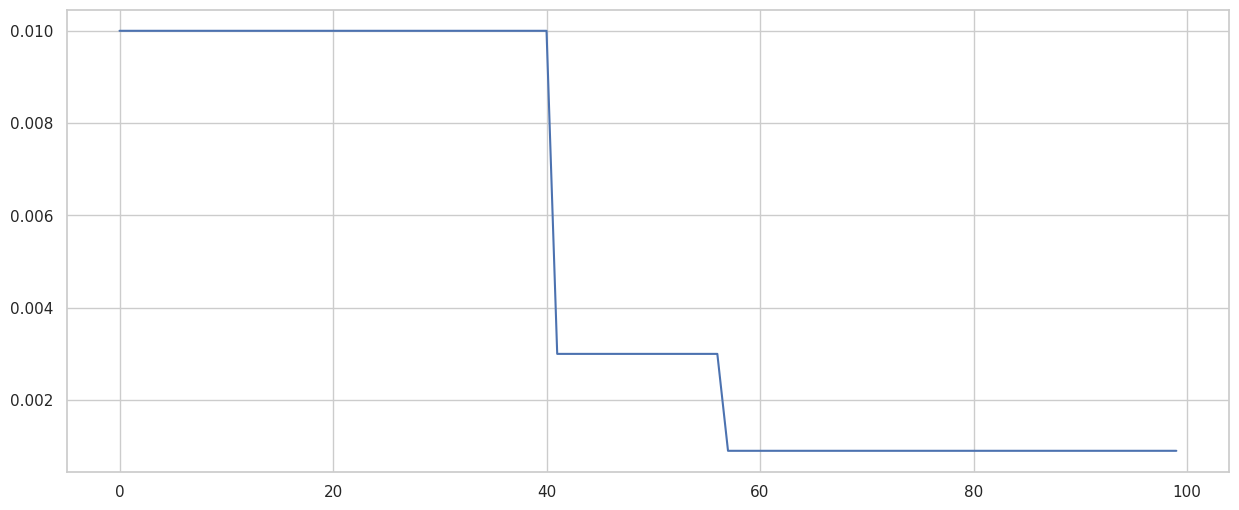

In [102]:
plt.plot(lr);

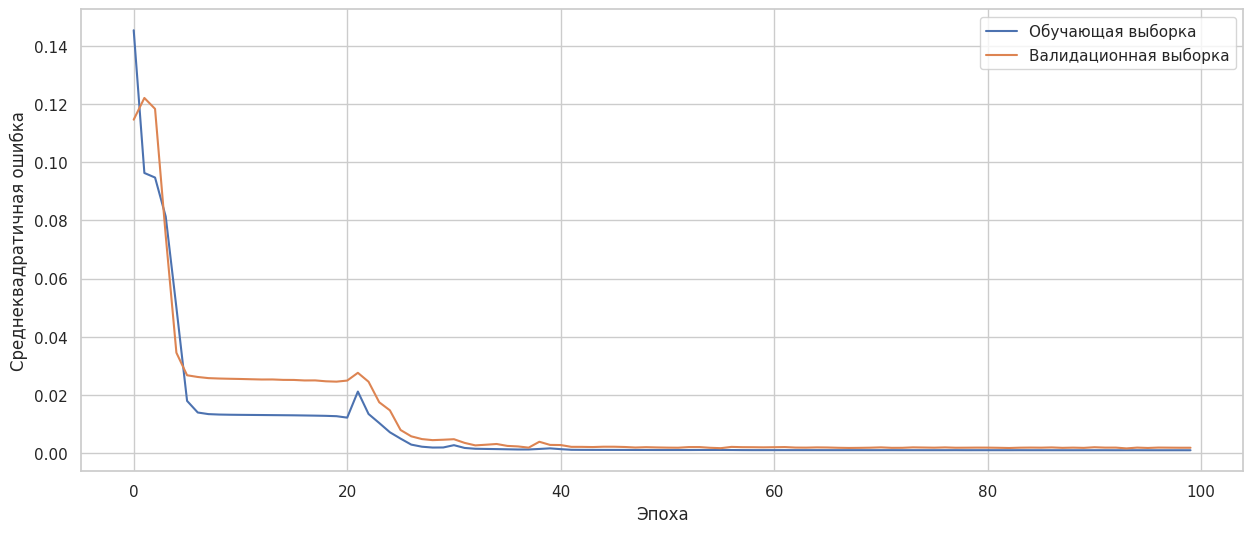

In [103]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Валидационная выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

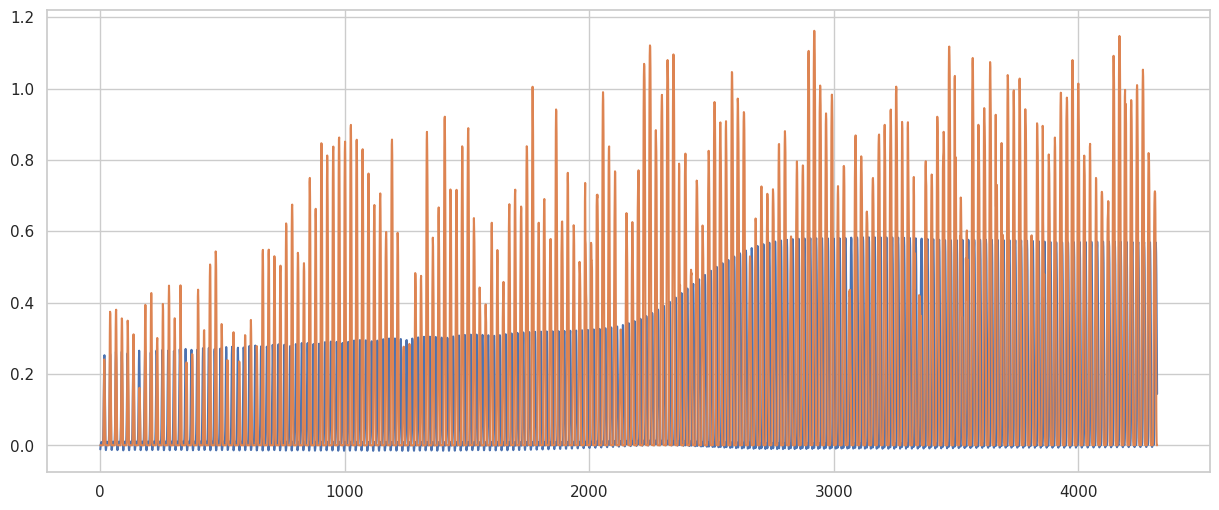

In [104]:
LSTM_model_2.to('cpu')

horizon_for_test = solar_test_scaled.shape[0] - N_LAGS

pred = LSTM_model_2(
    torch.tensor(
        solar_test_scaled.values[:N_LAGS][None,:,:],
        dtype=torch.float32),
    horizon_for_test
    # solar_test_scaled.shape[0] - N_LAGS
    )

plt.plot(pred[0,:,0].detach().numpy());
plt.plot(solar_test_scaled.values[N_LAGS:N_LAGS+horizon_for_test][:,0]);

FeedForwardNN(
  (linear): ModuleList(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (out): Linear(in_features=1024, out_features=100, bias=True)
)

In [48]:
print(f"Число параметров FC модели: {sum(p.numel() for p in FC_model.parameters() if p.requires_grad)}")
print(f"Число параметров LSTM модели: {sum(p.numel() for p in LSTM_model.parameters() if p.requires_grad)}")
print(f"Число параметров LSTM модели с доп. признаками: {sum(p.numel() for p in LSTM_model_2.parameters() if p.requires_grad)}")

Число параметров FC модели: 1163364
Число параметров LSTM модели: 17217
Число параметров LSTM модели с доп. признаками: 17859
